In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
from scipy.optimize import minimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import _b
import gzbuilder_analysis.fitting as fitting
from asinh_cmap import asinh_cmap

In [3]:
subject_id = 20902011
model_type = 'aggregate'

In [ ]:
agg_res = pd.read_pickle('output_

In [ ]:
from gzbuilder_analysis.rendering import jax2
m = pg.from_pandas(agg_res.params)
new_model = jax2.restructure_model(m)
reparametrized_model = jax2.to_reparametrization(new_model)
errs = pg.from_pandas(agg_res.errors.reindex_like(agg_res.params).replace(np.nan, np.inf))
errs = jax2.restructure_model(errs)
errs['spiral'].pop('points')
errs = jax2.get_errors_in_reparmetrization(errs)

jax2.render(errs)

In [4]:
models = pd.read_pickle('lib/models.pickle')
err_df = pd.read_csv('lib/errors.csv', index_col=0, header=[0, 1])
diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')
model_dict = deepcopy(models.loc[subject_id][model_type])
diff_data = diff_data_df.loc[subject_id]
psf = diff_data['psf']
data = diff_data['galaxy_data']
sigma_image = diff_data['sigma_image']

In [5]:
def plot_difference(diff, ax=None):
    ax = ax if ax is not None else plt.gca()
    l = np.abs(diff).max()
    ax.imshow(diff, cmap='seismic', vmin=-l, vmax=l)

Define errors on aggregate parameters (ignoring sliders):

In [6]:
param_errs = err_df.loc[subject_id].replace(0, np.nan).drop(
    [(k, c) for k in ('disk', 'bulge', 'bar') for c in ('I', 'n', 'c')]
).dropna()

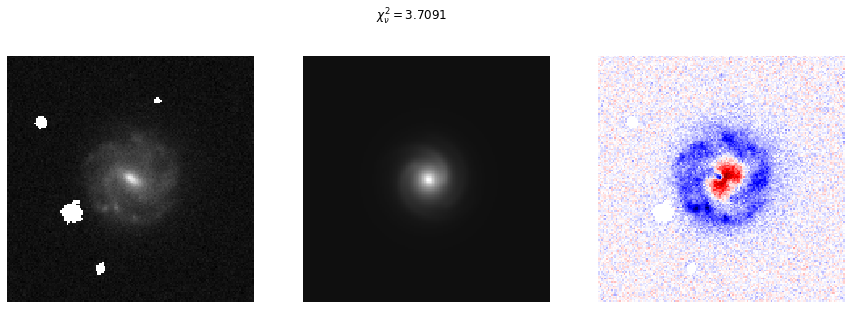

In [7]:
model_obj = fitting.Model(
    model_dict,
    data,
    psf=psf,
    sigma_image=sigma_image,
    param_sigma=param_errs
)
r = model_obj.render()
kw = dict(
    cmap=asinh_cmap,
    vmin=min(data.min(), r.min()),
    vmax=max(data.max(), r.max())
)
f, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(model_obj.data, **kw)
ax[1].imshow(model_obj.render(), **kw)
# ax[2].imshow(r - data, cmap='seismic', vmin=-1, vmax=1)
plot_difference(r - data, ax[2])
cq = fitting.chisq(r, data, sigma_image)
plt.suptitle(r'$\chi_\nu^2 = {:.4f}$'.format(cq))
[a.axis('off') for a in ax];

In [8]:
(
    model_obj.params.round(3).astype(str)
    + ' ± '
    + param_errs.round(4).reindex_like(model_obj.params.dropna()).astype(str)
).unstack().T

component,bar,bulge,disk,spiral0,spiral1,spiral2
parameter,,,,,,
I,0.1 ± nan,0.2 ± nan,0.2 ± nan,0.1 ± nan,0.1 ± nan,0.1 ± nan
Re,2.67 ± 0.2082,1.311 ± 0.0384,11.686 ± 0.5886,NaN,NaN,NaN
c,2.0 ± nan,2.0 ± nan,2.0 ± nan,NaN,NaN,NaN
falloff,NaN,NaN,NaN,1.0 ± nan,1.0 ± nan,1.0 ± nan
mux,77.225 ± 0.2708,77.07 ± 0.1469,77.528 ± 0.2741,NaN,NaN,NaN
muy,76.637 ± 0.1766,76.695 ± 0.0759,76.719 ± 0.2763,NaN,NaN,NaN
n,1.0 ± nan,1.0 ± nan,1.0 ± nan,NaN,NaN,NaN
q,0.51 ± 0.0819,0.664 ± 0.1796,0.969 ± 0.1186,NaN,NaN,NaN
roll,2.183 ± 1.1276,2.005 ± 1.2848,0.123 ± 1.8227,NaN,NaN,NaN


We will reparametrize secondary components to be with respect to the disk

|Original | New        | Limits |
|---------|------------|--------|
| $R_e$   | $\frac{R_e}{R_{e, \mathrm{disc}}}$ | (0, 1) |
| $I$     | $\frac{L_{tot}}{L_{tot} + L_{tot, \mathrm{disc}}}$  | (0, 1) |
| $\mu$     | $\mu - \mu_\mathrm{disc}$  | (-inf, inf) | 

Sersic total luminosity is given by

$$L_{\mathrm{tot}} = 2\pi\,IR_e^2n\frac{e^{b_n}}{(b_n)^{2n}}\Gamma(2n)$$

In [9]:
def sersic_ltot(comp):
    return (
        2 * np.pi * comp['I'] * comp['Re']**2 * comp['n']
        * np.exp(_b(comp['n'])) / _b(comp['n'])**(2 * comp['n'])
        * gamma(2 * comp['n'])
    )


def sersic_I(comp):
    return comp['L'] / (
        2 * np.pi * comp['Re']**2 * comp['n']
        * np.exp(_b(comp['n'])) / _b(comp['n'])**(2 * comp['n'])
        * gamma(2 * comp['n'])
    )

In [10]:
def get_new_params(p):
    # go from original param specification to new
    p_new = p.copy()
    disk_l = sersic_ltot(p['disk'])
    p_new[('disk', 'L')] = disk_l
    p_new.drop(('disk', 'I'), inplace=True)
    for c in ('bulge', 'bar'):
        try:
            comp_l = sersic_ltot(p[c])
            p_new[(c, 'Re')] =  p[(c, 'Re')] / p[('disk', 'Re')]
            p_new[(c, 'mux')] =  p[(c, 'mux')] - p[('disk', 'mux')]
            p_new[(c, 'muy')] =  p[(c, 'muy')] - p[('disk', 'muy')]
            p_new[(c, 'L')] =  sersic_ltot(p[c]) / (disk_l + comp_l)
            p_new.drop((c, 'I'), inplace=True)
        except KeyError:
            pass
    return p_new

def get_original_params(p):
    # go from new param specification to original
    p_new = p.copy()
    disk_I = sersic_I(p['disk'])
    p_new[('disk', 'I')] = disk_I
    p_new.drop(('disk', 'L'), inplace=True)
    for c in ('bulge', 'bar'):
        try:
            p_new[(c, 'Re')] =  p[(c, 'Re')] * p[('disk', 'Re')]
            p_new[(c, 'mux')] =  p[(c, 'mux')] + p[('disk', 'mux')]
            p_new[(c, 'muy')] =  p[(c, 'muy')] + p[('disk', 'muy')]
            comp_l = p[('disk', 'L')] * p[(c, 'L')] / (1 - p[(c, 'L')])
            p_new[(c, 'L')] = comp_l
            p_new[(c, 'I')] = sersic_I(p_new[c])
            p_new.drop((c, 'L'), inplace=True)
        except KeyError as e:
            pass
    return p_new

In [11]:
def get_bulge_tot(params):
    b = sersic_ltot(params['bulge'])
    return b / (b + sersic_ltot(params['disk']))

Get the model's parameters in the new parameterization

In [12]:
base_p = model_obj.params.dropna()
base_p = (base_p.xs('Re', level=1, drop_level=False) * 1.5).combine_first(base_p)
all_p = get_new_params(base_p.dropna())

Define limts on parameters:

In [13]:
lims_df = pd.DataFrame([], index=all_p.index, columns=('lower', 'upper'))

lims_df['lower'] = -np.inf
lims_df['upper'] = np.inf

lims_df.loc[('disk', 'L')] = (0, np.inf)
lims_df.loc[('disk', 'Re')] = (0.01, np.inf)
lims_df.loc[('disk', 'q')] = (0.2, 1.2)
lims_df.drop(('disk', 'n'), inplace=True)  # do not fit disk n
lims_df.drop(('disk', 'c'), inplace=True)  # do not fit disk c
if model_obj['bulge'] is not None:
    lims_df.loc[('bulge', 'L')] = (0, 1-0.01)
    lims_df.loc[('bulge', 'Re')] = (0, 1)
    lims_df.loc[('bulge', 'q')] = (0.6, 1.1)
    lims_df.loc[('bulge', 'n')] = (0.5, 5)
    lims_df.drop(('bulge', 'c'), inplace=True)  # do not fit bulge c
if model_obj['bar'] is not None:
    lims_df.loc[('bar', 'L')] = (0, 1-0.01)
    lims_df.loc[('bar', 'Re')] = (0, 1)
    lims_df.loc[('bar', 'q')] = (0.05, 1.2)
    lims_df.loc[('bar', 'n')] = (0.3, 5)
    lims_df.loc[('bar', 'c')] = (0.5, 6)
if len(model_obj['spiral']) > 0:
    for i in range(len(model_obj['spiral'])):
        lims_df.loc[(f'spiral{i}', 'I')] = (0, np.inf)
        lims_df.loc[(f'spiral{i}', 'spread')] = (0, np.inf)
        lims_df.loc[(f'spiral{i}', 'falloff')] = (0.01, np.inf)

lims_df.sort_index(inplace=True)

Only fit luminosity at first:

In [14]:
lims_df_initial = lims_df.copy()

lims_df_initial.drop(('disk', 'Re'), inplace=True)
lims_df_initial.drop(('disk', 'q'), inplace=True)

if model_obj['bulge'] is not None:
    lims_df_initial.drop(('bulge', 'Re'), inplace=True)
    lims_df_initial.drop(('bulge', 'q'), inplace=True)
    lims_df_initial.drop(('bulge', 'n'), inplace=True)
if model_obj['bar'] is not None:
    lims_df_initial.drop(('bar', 'Re'), inplace=True)
    lims_df_initial.drop(('bar', 'q'), inplace=True)
    lims_df_initial.drop(('bar', 'n'), inplace=True)
    lims_df_initial.drop(('bar', 'c'), inplace=True)
if len(model_obj['spiral']) > 0:
    for i in range(len(model_obj['spiral'])):
        lims_df_initial.loc[(f'spiral{i}', 'I')] = (0, np.inf)
        lims_df_initial.loc[(f'spiral{i}', 'spread')] = (0, np.inf)
        lims_df_initial.loc[(f'spiral{i}', 'falloff')] = (0.01, np.inf)

lims_df_initial.sort_index(inplace=True)

Define the function to minimize:

In [15]:
def get_nnlf(p, model_obj, lims, all_params):
    p_ = pd.Series(p, index=lims.index).combine_first(all_params).reindex_like(all_params)
    p_original = get_original_params(p_)
    return model_obj.nnlf(p_original)

def get_chisq(p, model_obj, lims, all_params):
    p_ = pd.Series(p, index=lims.index).combine_first(all_params).reindex_like(all_params)
    r = model_obj.render(params=get_original_params(p_))
    if np.any(np.isnan(r)):
        print('NaN in render')
        print(get_original_params(p_).unstack())
        raise(ValueError)
    cq = fitting.chisq(r, model_obj.data, model_obj.sigma_image)
    if np.isnan(cq):
        return 1E5
    return cq

Perform the initial optimization:

In [16]:
with tqdm(leave=True) as pbar:
    def update_bar(*args):
        pbar.update(1)
#         pbar.set_description(f'NNLF={get_nnlf(args[0], model_obj, lims_df_initial, all_p):.4f}')
        pbar.set_description(f'chisq = {get_chisq(args[0], model_obj, lims_df_initial, all_p):.4f}')
    res = minimize(
        get_nnlf,
        all_p.reindex_like(lims_df_initial),
        args=(model_obj, lims_df_initial, all_p),
        bounds=lims_df_initial.values,
        callback=update_bar,
        options=dict(maxiter=20),
    )

chisq = 3.3463: : 20it [01:58,  5.93s/it]


In [17]:
tuned_params = get_original_params(
    pd.Series(res['x'], index=lims_df_initial.index).combine_first(all_p)
).sort_index()

In [18]:
scaled_param_errs = (param_errs.xs('Re', level=1, drop_level=False) * 10).combine_first(param_errs)

In [19]:
model_obj2 = fitting.Model(
    model_obj.to_dict(tuned_params),
    data,
    psf=psf,
    sigma_image=sigma_image,
    param_sigma=scaled_param_errs,
)

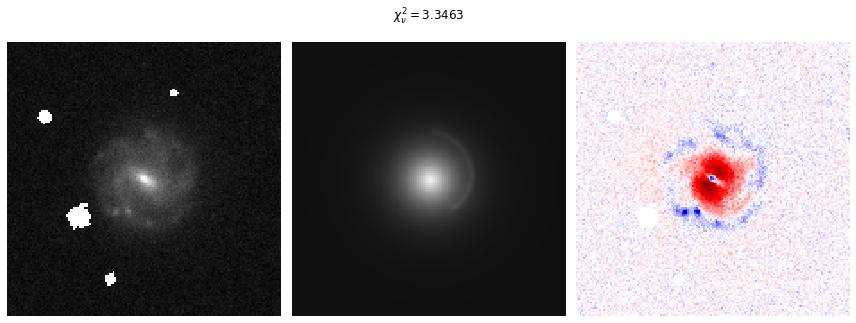

In [20]:
r = model_obj2.render()
kw = dict(
    cmap=asinh_cmap,
    vmin=min(data.min(), r.min()),
    vmax=max(data.max(), r.max())
)
f, ax = plt.subplots(ncols=3, figsize=(12, 5))
ax[0].imshow(data, **kw)
ax[1].imshow(r, **kw)
plot_difference(r - data, ax[2])
cq = fitting.chisq(r, data, sigma_image)
plt.suptitle(r'$\chi_\nu^2 = {:.4f}$'.format(cq))
[a.axis('off') for a in ax];
plt.tight_layout()

Perform the full optimization:

In [21]:
all_p2 = get_new_params(model_obj2.params.dropna())
with tqdm(leave=True) as pbar:
    def update_bar(*args):
        pbar.update(1)
#         pbar.set_description(f'NNLF={get_nnlf(args[0], model_obj, lims_df, all_p):.4f}')
        pbar.set_description(f'chisq = {get_chisq(args[0], model_obj, lims_df, all_p):.4f}')
    res = minimize(
        get_nnlf,
        all_p2.reindex_like(lims_df),
        args=(model_obj2, lims_df, all_p2),
        bounds=lims_df.values,
        callback=update_bar,
        options=dict(maxiter=100),
    )

chisq = 1.4949: : 64it [07:23,  6.00s/it]/Users/tlingard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/tlingard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/tlingard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
chisq = 1.4466: : 100it [11:44,  7.05s/it]


In [22]:
final_params = get_original_params(
    pd.Series(res['x'], index=lims_df.index).combine_first(all_p2)
).sort_index()
final_params.unstack()

parameter,I,Re,c,mux,muy,n,q,roll,falloff,spread
component,,,,,,,,,,
bar,1.354963,4.963948,2.038562,77.081308,76.545823,0.575056,0.065749,2.102432,NaN,NaN
bulge,0.061363,1.217512,2.000000,76.990787,77.110662,0.955649,0.939464,2.122326,NaN,NaN
disk,0.094847,25.429603,2.000000,77.348439,76.898842,1.000000,0.859428,0.631456,NaN,NaN
spiral0,0.216050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.852890,0.212380
spiral1,0.010902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061506,1.747130
spiral2,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.644633,0.366693


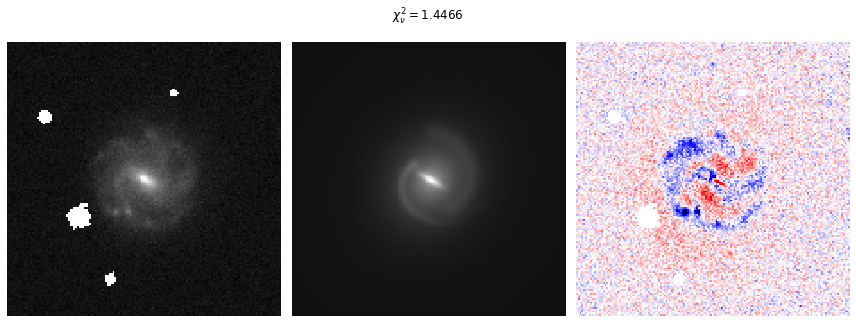

In [23]:
r = model_obj2.render(params=final_params)
kw = dict(
    cmap=asinh_cmap,
    vmin=min(data.min(), r.min()),
    vmax=max(data.max(), r.max())
)
f, ax = plt.subplots(ncols=3, figsize=(12, 5))
ax[0].imshow(data, **kw)
ax[1].imshow(r, **kw)
plot_difference(r - data, ax[2])
cq = fitting.chisq(r, data, sigma_image)
plt.suptitle(r'$\chi_\nu^2 = {:.4f}$'.format(cq))
[a.axis('off') for a in ax];
plt.tight_layout()

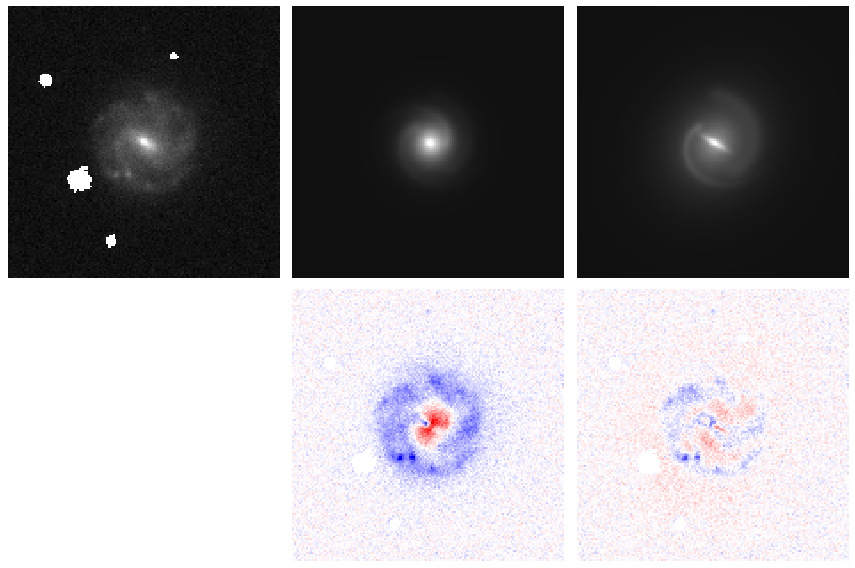

In [24]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax[0][0].imshow(model_obj.data, **kw)
ax[0][1].imshow(model_obj.render(model=model_dict), **kw)
ax[0][2].imshow(model_obj.render(params=final_params), **kw)
ax[1][1].imshow(model_obj.render(model=model_dict) - model_obj.data, vmin=-0.5, vmax=0.5, cmap='seismic')
ax[1][2].imshow(model_obj.render(params=final_params) - model_obj.data, vmin=-0.5, vmax=0.5, cmap='seismic')
[a.axis('off') for a in ax.ravel()];
plt.tight_layout()

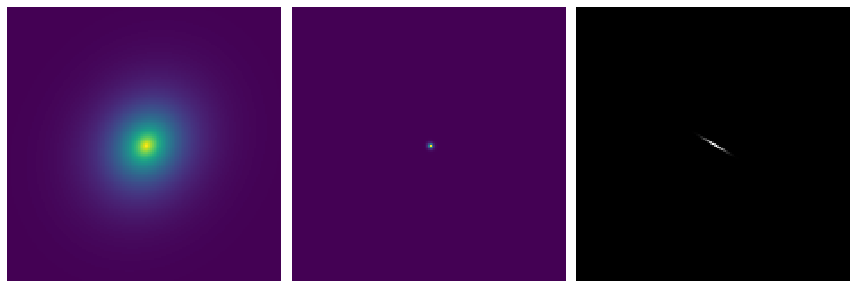

In [25]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
ax[0].imshow(model_obj._cache['disk'])
ax[1].imshow(model_obj._cache['bulge'])
ax[2].imshow(model_obj._cache['bar'], cmap=asinh_cmap)
[a.axis('off') for a in ax.ravel()];
plt.tight_layout()

In [26]:
final_model_obj = fitting.Model(
    model_obj.to_dict(final_params),
    data,
    psf=psf,
    sigma_image=sigma_image,
    param_sigma=param_errs,
)

How have these parameters changed from the initial conditions?

In [27]:
pd.concat((
    all_p.rename('Initial'),
    final_model_obj.sanitize().dropna().rename('Final'),
    (final_model_obj.sanitize().dropna() - parsing.to_pandas(model_dict)).rename('delta'),
    param_errs.round(4).reindex_like(model_obj.params.dropna()).rename('Errors')
),axis=1)

Initial      Final      delta  Errors
component parameter                                          
bar       I                 NaN   1.354963   1.254963     NaN
          L            0.025436        NaN        NaN     NaN
          Re           0.228474   4.963948   2.293991  0.2082
          c            2.000000   2.038562   0.038562     NaN
          mux         -0.303100  77.081308  -0.143481  0.2708
          muy         -0.081739  76.545823  -0.090992  0.1766
          n            1.000000   0.575056  -0.424944     NaN
          q            0.510397   0.065749  -0.444648  0.0819
          roll         2.182959   2.102432  -0.080527  1.1276
bulge     I                 NaN   0.061363  -0.138637     NaN
          L            0.012438        NaN        NaN     NaN
          Re           0.112224   1.217512  -0.093941  0.0384
          c            2.000000   2.000000   0.000000     NaN
          mux         -0.457721  76.990787  -0.079380  0.1469
          muy         -0.023408  77.110662   0.415514  0.0759
          n            1.000000   0.955649  -0.044351     NaN
          q            0.664263   0.939464   0.275201  0.1796
          roll         2.004926   2.122326   0.117400  1.2848
disk      I                 NaN   0.094847  -0.105153     NaN
          L          734.272532        NaN        NaN     NaN
          Re          17.529066  25.429603  13.743559  0.5886
          c            2.000000   2.000000   0.000000     NaN
          mux         77.527889  77.348439  -0.179450  0.2741
          muy         76.718555  76.898842   0.180287  0.2763
          n            1.000000   1.000000   0.000000     NaN
          q            0.968663   0.859428  -0.109235  0.1186
          roll         0.122913   0.631456   0.508543  1.8227
spiral0   I            0.100000   0.216050   0.116050     NaN
          falloff      1.000000   1.852890   0.852890     NaN
          spread       0.500000   0.212380  -0.287620     NaN
spiral1   I            0.100000   0.010902  -0.089098     NaN
          falloff      1.000000   0.061506  -0.938494     NaN
          spread       0.500000   1.747130   1.247130     NaN
spiral2   I            0.100000   0.000000  -0.100000     NaN
          falloff      1.000000   4.644633   3.644633     NaN
          spread       0.500000   0.366693  -0.133307     NaN

In [28]:
(final_model_obj.sanitize().dropna() - parsing.to_pandas(model_dict)).unstack()

parameter,I,Re,c,falloff,mux,muy,n,q,roll,spread
component,,,,,,,,,,
bar,1.254963,2.293991,0.038562,NaN,-0.143481,-0.090992,-0.424944,-0.444648,-0.080527,NaN
bulge,-0.138637,-0.093941,0.000000,NaN,-0.079380,0.415514,-0.044351,0.275201,0.117400,NaN
disk,-0.105153,13.743559,0.000000,NaN,-0.179450,0.180287,0.000000,-0.109235,0.508543,NaN
spiral0,0.116050,NaN,NaN,0.852890,NaN,NaN,NaN,NaN,NaN,-0.287620
spiral1,-0.089098,NaN,NaN,-0.938494,NaN,NaN,NaN,NaN,NaN,1.247130
spiral2,-0.100000,NaN,NaN,3.644633,NaN,NaN,NaN,NaN,NaN,-0.133307


## Measuring bulge fraction:

In [30]:
gzb_bt = np.sum(final_model_obj._cache['bulge'] + final_model_obj._cache['bar']) / final_model_obj.render().sum()

In [31]:
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
lackner_nb1 = pd.read_csv('lib/lackner_nb1.csv', index_col=0)
lackner_nb4 = pd.read_csv('lib/lackner_nb4.csv', index_col=0)

In [61]:
print(f'Galaxy Builder: {gzb_bt:.3f}')
try:
    print(
        'Lackner nb1: ',
        '{:.4f} ± {:.5f}'.format(*lackner_nb1.loc[subject_id][['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']])
    )
    print(
        'Lackner nb4: ',
        '{:.4f} ± {:.5f}'.format(*lackner_nb4.loc[subject_id][['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']])
    )
except KeyError:
    print(f'Subject id {subject_id} not present in Lackner & Gunn (2012)')
try:
    print(
        'Simard nb4: ', 
        '{:.4f} ± {:.5f}'.format(*simard_df.loc[subject_id][['__B_T_r', 'e__B_T_r']])
    )
    print(
        'Simard free:',
        '{:.4f} ± {:.5f}'.format(*simard_df_free.loc[subject_id][['__B_T_r', 'e__B_T_r']])
    )
except KeyError:
    print(f'Subject id {subject_id} not present in Simard (2011)')

Galaxy Builder: 0.032
Subject id 20902011 not present in Lackner & Gunn (2012)
Simard nb4:  0.0500 ± 0.00000
Simard free: 0.0500 ± 0.00000
